# README

This notebook runs on Google Colab

The Source file **results.csv** should locate in the same directory of the notebook


# Functions

In [0]:
def insertDF(the_df, model_name, value, transform_name, key_col="Model"):
    if(the_df.loc[the_df[key_col] == model_name].empty):
      n_r = len(the_df)
      the_df.loc[n_r] = None
      the_df.loc[n_r, key_col] = model_name

    idx = the_df.loc[the_df[key_col] == model_name][transform_name].index
    the_df.loc[idx, transform_name] = value
    return  the_df

def clean_model_name(name):
  if name == 'Adaboost Classifier':
    name = 'Adaboost'
  elif name == 'AdaBoost Classifier':
    name = 'Adaboost'
  elif name == 'Random Forest Classifier':
    name = 'Random Forest'
  
  return  name

def exec_slice_result(df, year):
  df_ori = pd.DataFrame(columns=['Model', 'Actual', 'First Order', 'Second Order', 
                                 'First Order (NASDAQ & Currencies Excluded)', 
                                 'Second Order (NASDAQ & Currencies Excluded)', 
                                 'First Order (15day Window)', 'Second Order (15day Window)', 
                                 'First Order (NASDAQ & Currencies Excluded, 15day Window)', 
                                 'Second Order (NASDAQ & Currencies Excluded, 15day Window)',
                                 'Stationary'])
  result = df_ori

  for r_i, r in df.iterrows():
    model_name = df.iloc[r_i]['Model']

    model_name = clean_model_name(model_name)

    # Get Value
    value = df.iloc[r_i]['%age correct']
    if isinstance(value, str):
      value = value.replace('%', '')
    value = float(value)
    if value == None:
      continue


    # df.loc[r_i, ('%age correct')] = value
    
    if df.iloc[r_i]['# of years'] == year:

      excluded = df.iloc[r_i]['feature excluded']
      comments = df.iloc[r_i]['comments']

      if not isinstance(excluded, str):
        continue

      if 'NASDAQ' in excluded:
        if 'first order' in comments:
          transform_name = 'First Order (NASDAQ & Currencies Excluded)'
          if 'window' in comments:
            transform_name = 'First Order (NASDAQ & Currencies Excluded, 15day Window)'
        else:  # elif 'second order' in comments:
          transform_name = 'Second Order (NASDAQ & Currencies Excluded)'
          if 'window' in comments:
            transform_name = 'Second Order (NASDAQ & Currencies Excluded, 15day Window)'
      else:  # elif 'Date in exclude':
        if 'first order' in comments:
          transform_name = 'First Order'
          if 'window' in comments:
            transform_name = 'First Order (15day Window)'
        else:  # elif 'second order' in comments:
          transform_name = 'Second Order'
          if 'window' in comments:
            transform_name = 'Second Order (15day Window)'

      if 'Preliminary' in comments:
        transform_name = 'Actual'
      elif 'Stationary' in comments:
        transform_name = 'Stationary'
      # print(model_name, value, transform_name)
      insertDF(result, model_name, value, transform_name)
  return  result

def slice_result(df):
  df_5yr = exec_slice_result(df, 5)
  df_10yr = exec_slice_result(df, 10)
  return  df_5yr, df_10yr

def plot_result(df_master, series, k='Model', width=5, y_lower=45, y_upper=65, legend_y=-.5):
  # print(k)
  # print(df_master.columns)
  chart = df_master.plot.bar(x=k, y=series, rot=0, figsize=(width,5), cmap = 'YlGn', edgecolor = 'black')
  chart.legend(loc='lower right', bbox_to_anchor=(1, legend_y))
  chart.set_ylim(y_lower, y_upper)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
  chart.set_yticklabels(['{:,.0%}'.format(x / 100) for x in chart.get_yticks()])
  
  '''
  mean1 = df_master["First Order"].mean()
  chart.axhline(mean1, linewidth = 1, 
                color=(.8,.8,.5), linestyle='--')
  mean2 = df_master["Second Order"].mean()
  chart.axhline(mean2, linewidth = 1, 
                color=(.3,.6,.3), linestyle='--')
  '''

#Setup


Number of Results: 147
                 Model First Order Second Order First Order (NASDAQ & Currencies Excluded) Second Order (NASDAQ & Currencies Excluded) First Order (15day Window) Second Order (15day Window) First Order (NASDAQ & Currencies Excluded, 15day Window) Second Order (NASDAQ & Currencies Excluded, 15day Window) Stationary
0             Adaboost       59.56        59.76                                      62.17                                       57.14                      50.62                       53.94                                              54.77                                                    50.62              59.8
1        Random Forest       51.11        53.72                                      51.11                                       54.12                      53.53                       54.56                                              55.81                                                    55.39              50.4
2                  SVM       

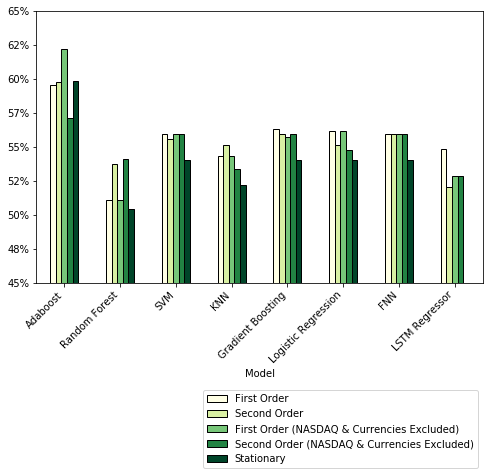

In [114]:
def setup():
  import pandas as pd
  import tqdm as tqdm
  import matplotlib as plt
  import numpy as np
  pd.set_option('display.max_rows', 50)
  pd.set_option('display.max_columns', 50)
  pd.set_option('display.width', 500)

  data = pd.read_csv('results.csv')
  print('Number of Results: ' + str(len(data)))
  # df = pd.DataFrame(columns=['Model', 'Actual', 'First Order', 'Second Order', 'First Order Denoised', 'Second Order Denoised', 'Stationary'])
  _, df_10y = slice_result(data)

  t = df_10y.drop(['Actual'], axis=1)

  print(t)
  plot_result(df_10y, ["First Order", "Second Order", "First Order (NASDAQ & Currencies Excluded)", 
              "Second Order (NASDAQ & Currencies Excluded)", "Stationary"], width=8, legend_y=-.7)
setup()

# Value Differencing


                 Model Actual First Order Second Order First Order (NASDAQ & Currencies Excluded) Second Order (NASDAQ & Currencies Excluded)
0             Adaboost     53       59.56        59.76                                      62.17                                       57.14
1        Random Forest   50.6       51.11        53.72                                      51.11                                       54.12
2                  SVM     53       55.93        55.53                                      55.94                                       55.94
3                  KNN   49.8       54.33        55.13                                      54.33                                       53.32
4    Gradient Boosting     56        56.3         55.9                                       55.7                                        55.9
5  Logistic Regression    NaN       56.13        55.13                                      56.14                                       54.73
6     

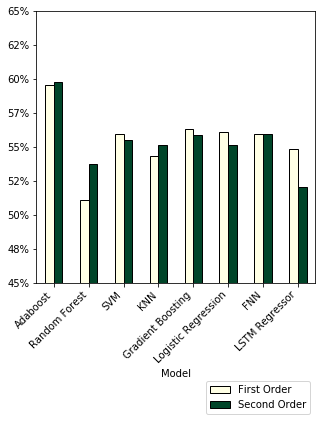

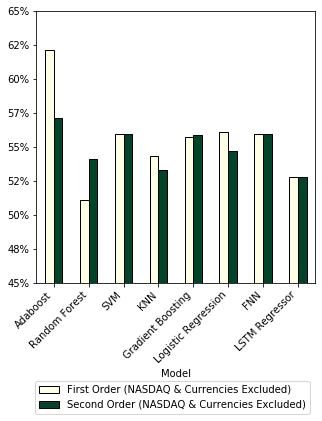

In [115]:
def get_result_feature_trans(t):
  t = t.drop(['First Order (15day Window)', 'Second Order (15day Window)', 
              'First Order (NASDAQ & Currencies Excluded, 15day Window)', 
              'Second Order (NASDAQ & Currencies Excluded, 15day Window)',
              'Stationary'], axis=1)
  print(t)
  t.to_csv('table_vd_ft.csv')

  plot_result(t, ["First Order", "Second Order"])
  plot_result(t, ["First Order (NASDAQ & Currencies Excluded)", "Second Order (NASDAQ & Currencies Excluded)"])

get_result_feature_trans(df_10y)

# Features Removal

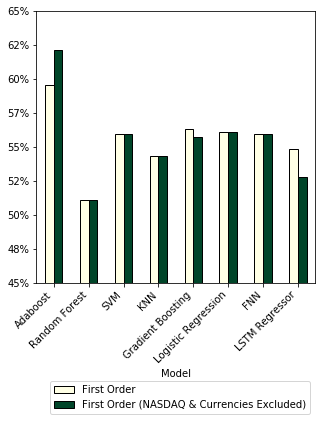

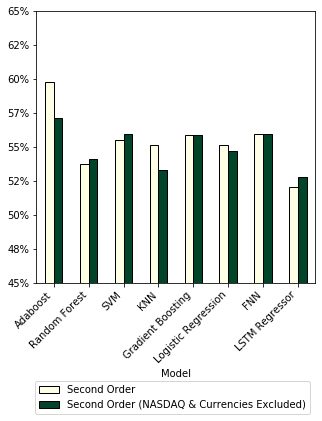

In [116]:
def get_result_order_diff(t):
  plot_result(t, ["First Order", "First Order (NASDAQ & Currencies Excluded)"])
  plot_result(t, ["Second Order", "Second Order (NASDAQ & Currencies Excluded)"])

get_result_order_diff(df_10y)

# Stationary

                 Model Stationary
0             Adaboost       59.8
1        Random Forest       50.4
2                  SVM         54
3                  KNN       52.2
4    Gradient Boosting         54
5  Logistic Regression         54
6                  FNN         54
7       LSTM Regressor        NaN
                 Model First Order First Order (NASDAQ & Currencies Excluded) Stationary
0             Adaboost       59.56                                      62.17       59.8
1        Random Forest       51.11                                      51.11       50.4
2                  SVM       55.93                                      55.94         54
3                  KNN       54.33                                      54.33       52.2
4    Gradient Boosting        56.3                                       55.7         54
5  Logistic Regression       56.13                                      56.14         54
6                  FNN       55.94                                     

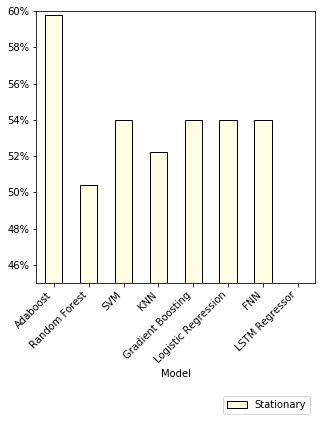

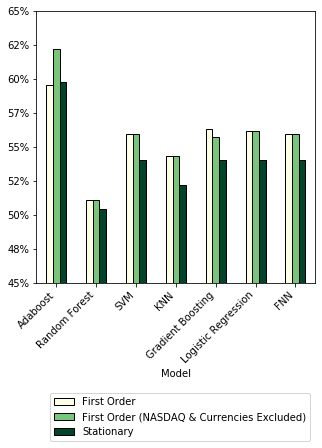

In [55]:
def get_result_stationary(t):
  cols = t.columns
  cols = cols.to_list()
  cols.remove('Stationary')
  cols.remove('Model')

  # print(cols)
  t_x = t.drop(cols, axis=1)
  print(t_x)
  t_x.to_csv('table_st_ex.csv')
  plot_result(t_x, ["Stationary"], y_lower=45, y_upper=60)

  t = t[["Model", 'First Order', 'First Order (NASDAQ & Currencies Excluded)', 'Stationary']]
  t = t[t['Model']!='LSTM Regressor']
  print(t)
  t.to_csv('table_st.csv')
  plot_result(t, ['First Order', 'First Order (NASDAQ & Currencies Excluded)', 'Stationary'], 
              y_lower=45, y_upper=65, legend_y=-.6)

get_result_stationary(df_10y)

In [56]:
plot_result(t_t, ["Average"], k='Trans', y_lower=50, y_upper=60)

NameError: ignored

# 15-day Window

                 Model First Order (15day Window) Second Order (15day Window) First Order (NASDAQ & Currencies Excluded, 15day Window) Second Order (NASDAQ & Currencies Excluded, 15day Window)
0             Adaboost                      50.62                       53.94                                              54.77                                                    50.62       
1        Random Forest                      53.53                       54.56                                              55.81                                                    55.39       
2                  SVM                      55.19                       55.19                                              55.19                                                    55.19       
3                  KNN                         50                       51.66                                                 50                                                    51.66       
4    Gradient Boosting             

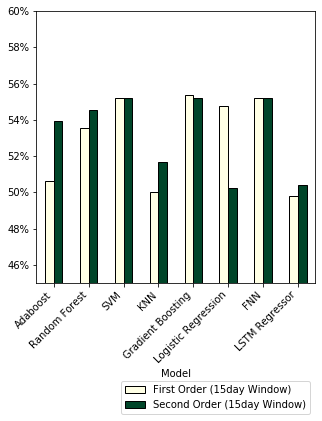

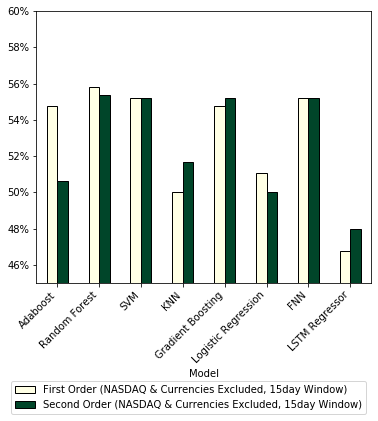

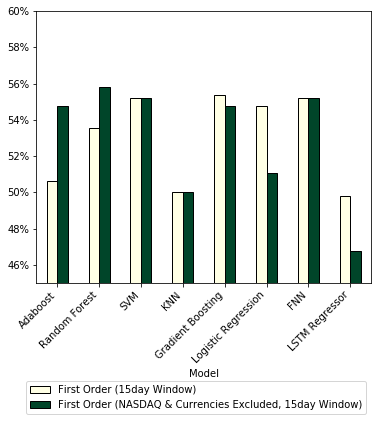

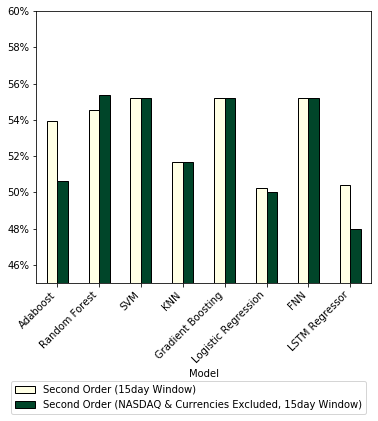

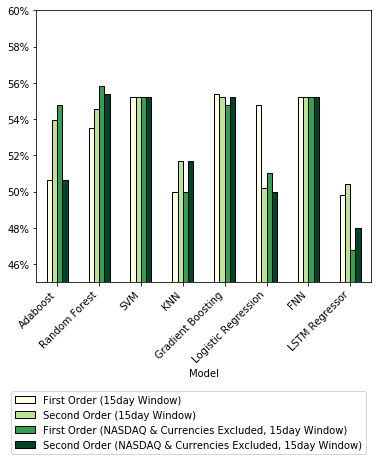

In [48]:
def get_result_15day_window(t):
  t = t.drop(['Actual', 'First Order', 'Second Order',
              'First Order (NASDAQ & Currencies Excluded)', 
              'Second Order (NASDAQ & Currencies Excluded)',
              'Stationary'], axis=1)
  print(t)
  t.to_csv('table_15d_w.csv')

  plot_result(t, ["First Order (15day Window)", "Second Order (15day Window)"], y_lower=45, y_upper=60)
  plot_result(t, ["First Order (NASDAQ & Currencies Excluded, 15day Window)", 
              "Second Order (NASDAQ & Currencies Excluded, 15day Window)"], y_lower=45, y_upper=60, width=6)
  plot_result(t, ["First Order (15day Window)", 
              "First Order (NASDAQ & Currencies Excluded, 15day Window)"], y_lower=45, y_upper=60, width=6)
  plot_result(t, ["Second Order (15day Window)", 
              "Second Order (NASDAQ & Currencies Excluded, 15day Window)"], y_lower=45, y_upper=60, width=6)
  plot_result(t, ["First Order (15day Window)", "Second Order (15day Window)", 
              "First Order (NASDAQ & Currencies Excluded, 15day Window)", 
              "Second Order (NASDAQ & Currencies Excluded, 15day Window)"], 
              y_lower=45, y_upper=60, legend_y=-.65, width=6)

get_result_15day_window(df_10y)

# Feature Transformation Accuracy

                                               Trans    Average
0                                             Actual  52.311429
1                                        First Order  55.517500
2                                       Second Order  55.391250
3         First Order (NASDAQ & Currencies Excluded)  55.518750
4        Second Order (NASDAQ & Currencies Excluded)  54.988750
5                         First Order (15day Window)  53.061250
6                        Second Order (15day Window)  53.292500
7  First Order (NASDAQ & Currencies Excluded, 15d...  52.942500
8  Second Order (NASDAQ & Currencies Excluded, 15...  52.655000
9                                         Stationary  54.057143


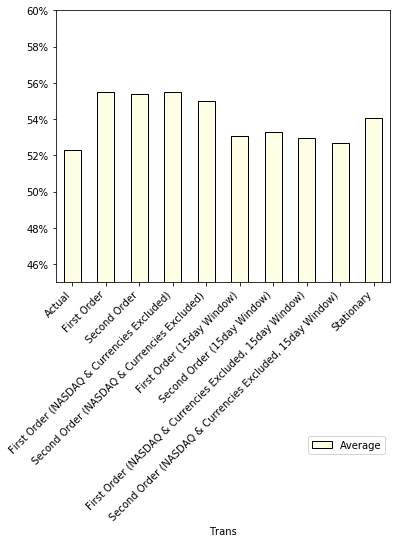

In [64]:
def get_trans_accuracy(df):
  result = pd.DataFrame(columns=["Trans", "Average"])
  for c_name in df.columns:
    if not c_name == 'Model':
      m = float(df[c_name].mean())
      result = result.append([{'Trans': c_name, 'Average': m}])
  result = result.reset_index()
  result = result.drop(['index'], axis=1)

  print(result)
  result.to_csv('table_accu.csv')

  plot_result(result, ["Average"], k="Trans", y_lower=45, y_upper=60, legend_y=-.65, width=6)

get_trans_accuracy(df_10y)

# Result Transpose

                                               Model Adaboost Random Forest    SVM    KNN Gradient Boosting Logistic Regression    FNN LSTM Regressor
0                                        First Order    59.56         51.11  55.93  54.33              56.3               56.13  55.94          54.84
1                                       Second Order    59.76         53.72  55.53  55.13              55.9               55.13  55.94          52.02
2         First Order (NASDAQ & Currencies Excluded)    62.17         51.11  55.94  54.33              55.7               56.14  55.94          52.82
3        Second Order (NASDAQ & Currencies Excluded)    57.14         54.12  55.94  53.32              55.9               54.73  55.94          52.82
4                         First Order (15day Window)    50.62         53.53  55.19     50             55.39               54.77  55.19           49.8
5                        Second Order (15day Window)    53.94         54.56  55.19  51.66           

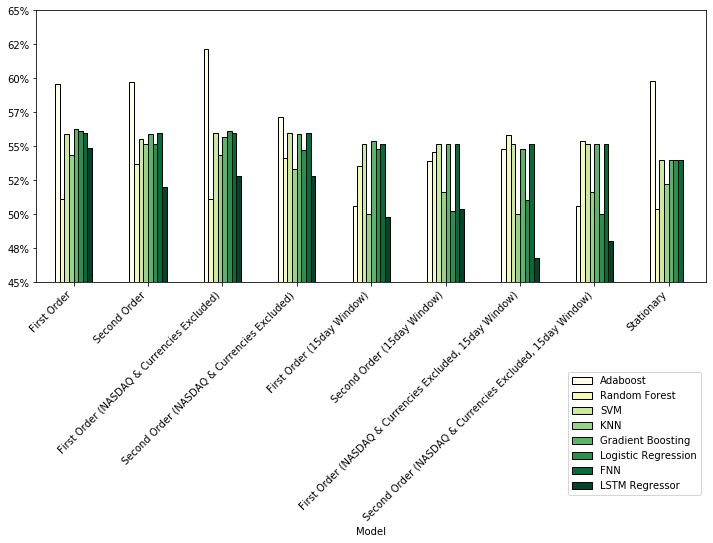

In [109]:
def get_result_transform(t):
  t_t = t

  cols = t_t.columns
  cols = cols.to_list()
  cols.remove('Actual')
  t_t = t_t[cols]
  
  t_t = t_t.set_index('Model', inplace=False).T
  t_t = t_t.reset_index()
  t_t = t_t.rename_axis(None, axis=1)
  n = 'Model'
  t_t = t_t.rename(columns={'index': n})
  print(t_t)

  cols = t_t.columns
  cols = cols.to_list()
  cols.remove('Model')

  plot_result(t_t, cols, width=12, legend_y=-.8)

get_result_transform(df_10y)